## Crude Oil

### Weekly

Epoch 1/100
10/10 [==============================] - 5s 208ms/step - loss: 0.1041 - val_loss: 0.0527
Epoch 2/100
10/10 [==============================] - 1s 141ms/step - loss: 0.0546 - val_loss: 0.0136
Epoch 3/100
10/10 [==============================] - 2s 149ms/step - loss: 0.0372 - val_loss: 0.0170
Epoch 4/100
10/10 [==============================] - 2s 155ms/step - loss: 0.0289 - val_loss: 0.0089
Epoch 5/100
10/10 [==============================] - 2s 150ms/step - loss: 0.0228 - val_loss: 0.0095
Epoch 6/100
10/10 [==============================] - 2s 154ms/step - loss: 0.0242 - val_loss: 0.0134
Epoch 7/100
10/10 [==============================] - 2s 165ms/step - loss: 0.0196 - val_loss: 0.0089
Epoch 8/100
10/10 [==============================] - 2s 166ms/step - loss: 0.0187 - val_loss: 0.0083
Epoch 9/100
10/10 [==============================] - 2s 162ms/step - loss: 0.0152 - val_loss: 0.0084
Epoch 10/100
10/10 [==============================] - 4s 470ms/step - loss: 0.0124 - val_lo

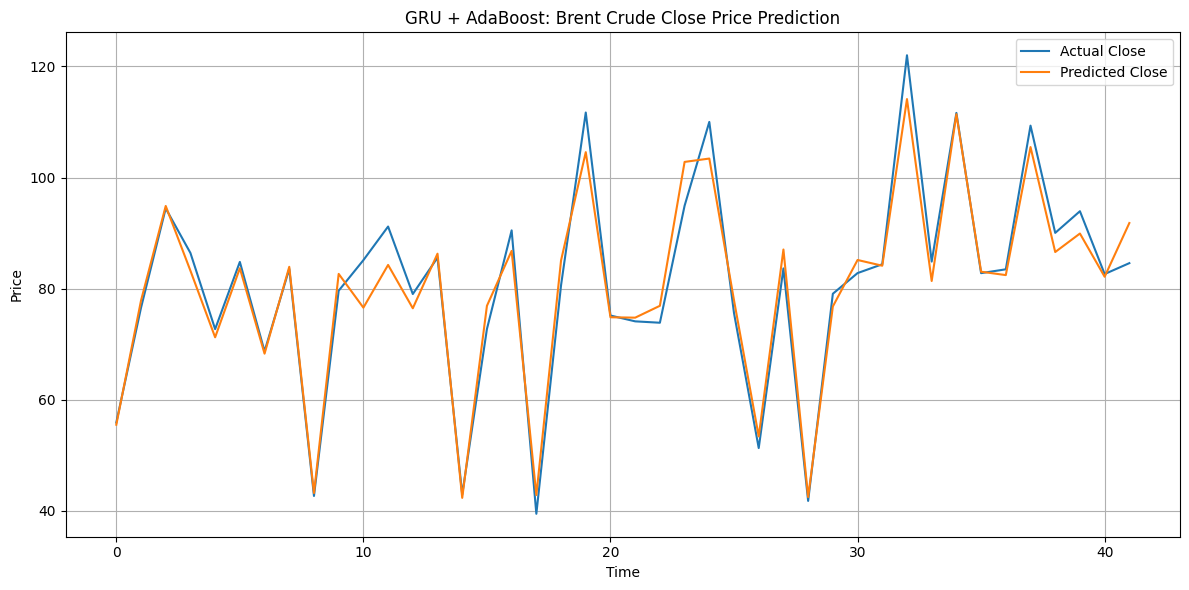

1/1 [==============================] - 1s 520ms/step

Future Brent Crude Oil Prices (Next 5 Weeks from 2024-09-08):
        Date  Predicted Close Price
0 2024-09-08              75.907500
1 2024-09-15              76.727719
2 2024-09-22              77.252414
3 2024-09-29              77.839216
4 2024-10-06              79.662319


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the data
df = pd.read_csv('brent_crude_oil_atr_ema_rsi_w.csv')
df.dropna(inplace=True)
df = df.tail(560)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[df.columns])
df_scaled = pd.DataFrame(scaled_values, columns=df.columns, index=df.index)

# Create sequences for GRU
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i, data.columns.get_loc("Close")])
    return np.array(X), np.array(y)

window_size = 350
X, y = create_sequence(df_scaled, window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build GRU model
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
gru_model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=16, callbacks=[early_stop], verbose=1)

# Extract GRU features
feature_extractor = Model(inputs=gru_model.input, outputs=gru_model.layers[-2].output)
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Train AdaBoost on extracted features
adaboost = AdaBoostRegressor(n_estimators=100, random_state=42)
adaboost.fit(X_train_features, y_train)

# Make predictions
predictions = adaboost.predict(X_test_features)

# Inverse transform predictions
predictions_rescaled = scaler.inverse_transform(np.column_stack([predictions, np.zeros((len(predictions), df_scaled.shape[1] - 1))]))
y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test, np.zeros((len(y_test), df_scaled.shape[1] - 1))]))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, df.columns.get_loc("Close")], predictions_rescaled[:, df.columns.get_loc("Close")]))
r2 = r2_score(y_test_rescaled[:, df.columns.get_loc("Close")], predictions_rescaled[:, df.columns.get_loc("Close")])
mape = np.mean(np.abs((y_test_rescaled[:, df.columns.get_loc("Close")] - predictions_rescaled[:, df.columns.get_loc("Close")]) / y_test_rescaled[:, df.columns.get_loc("Close")])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"R² (accuracy): {r2 * 100:.2f}%")
print(f"MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, df.columns.get_loc("Close")], label='Actual Close')
plt.plot(predictions_rescaled[:, df.columns.get_loc("Close")], label='Predicted Close')
plt.title("GRU + AdaBoost: Brent Crude Close Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predict next 5 weeks from 2024-09-08 with better variability
def predict_next_weeks_gru_adaboost(last_known_data, gru_model, adaboost_model, scaler, window_size=350, future_weeks=5):
    last_known_scaled = scaler.transform(last_known_data)
    future_predictions = []
    future_dates = []
    current_date = pd.to_datetime("2024-09-08")

    close_idx = df.columns.get_loc("Close")
    rsi_idx = df.columns.get_loc("RSI")
    ema_idx = [col for col in df.columns if "EMA" in col]
    ema_indices = [df.columns.get_loc(col) for col in ema_idx]

    for _ in range(future_weeks):
        X_last = np.array([last_known_scaled[-window_size:]])
        feature_extractor = Model(inputs=gru_model.input, outputs=gru_model.layers[-2].output)
        gru_features = feature_extractor.predict(X_last)
        predicted_close_scaled = adaboost_model.predict(gru_features)[0]

        predicted_row_scaled = last_known_scaled[-1].copy()
        predicted_row_scaled[close_idx] = predicted_close_scaled

        if rsi_idx:
            predicted_row_scaled[rsi_idx] += np.random.normal(0.005, 0.002)
        for idx in ema_indices:
            predicted_row_scaled[idx] += np.random.normal(0.002, 0.001)

        predicted_row_scaled = np.clip(predicted_row_scaled, 0, 1)
        last_known_scaled = np.vstack([last_known_scaled[1:], predicted_row_scaled])

        predicted_rescaled = scaler.inverse_transform(np.column_stack([[predicted_close_scaled], np.zeros((1, df_scaled.shape[1] - 1))]))
        predicted_close = predicted_rescaled[0, close_idx]

        future_predictions.append(predicted_close)
        future_dates.append(current_date)
        current_date += timedelta(weeks=1)

    return pd.DataFrame({'Date': future_dates, 'Predicted Close Price': future_predictions})

# Predict future weeks
last_known_data = df.tail(window_size)
future_df = predict_next_weeks_gru_adaboost(last_known_data, gru_model, adaboost, scaler, window_size)

print("\nFuture Brent Crude Oil Prices (Next 5 Weeks from 2024-09-08):")
print(future_df)


### Monthly

Epoch 1/70
18/18 [==============================] - 1s 15ms/step - loss: 0.0792 - val_loss: 0.0060
Epoch 2/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0104
Epoch 3/70
18/18 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0073
Epoch 4/70
18/18 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 5/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/70
18/18 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 8/70
18/18 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/70
18/18 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 10/70
18/18 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 11/70
18/18 

e:\TE MiniProject\venv\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



 RMSE: 8.64
Accuracy: 89.86%


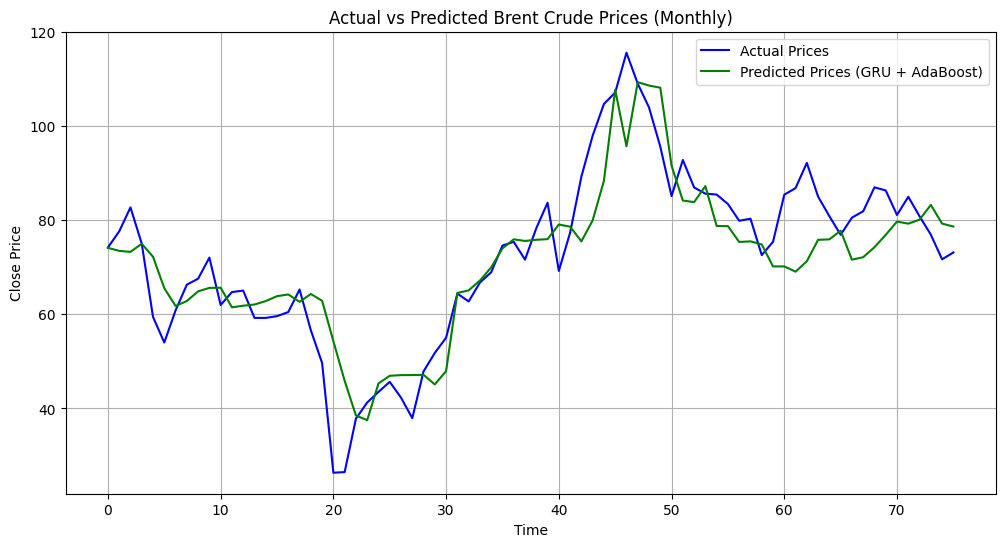

1/1 [==============================] - 0s 19ms/step

 Future Brent Crude Monthly Predictions:
        Date  Predicted Close Price
0 2024-11-01              78.669118
1 2024-12-01              78.772941
2 2025-01-01              79.387368
3 2025-02-01              80.121000
4 2025-03-01              78.772941


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('brent_crude_oil_atr_ema_rsi_m2.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

features = [
    'Open', 'High', 'Low', 'Vol.', 'ATR', 'EMA_10', 'EMA_20', 'RSI',
    's&p_500_Close', 's&p_500_ATR', 's&p_500_EMA_12', 's&p_500_EMA_26', 's&p_500_RSI',
    'cboe_Close', 'cboe_ATR', 'cboe_EMA_12', 'cboe_EMA_26', 'cboe_RSI',
    'usdi_Close', 'usdi_ATR', 'usdi_EMA_12', 'usdi_EMA_26', 'usdi_RSI'
]
target = 'Close'

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Create sequences
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(scaled_df.values, time_steps)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# GRU Model
gru_model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
gru_model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Extract GRU outputs
gru_train_pred = gru_model.predict(X_train)
gru_test_pred = gru_model.predict(X_test)

X_train_ab = np.hstack([X_train.reshape(X_train.shape[0], -1), gru_train_pred])
X_test_ab = np.hstack([X_test.reshape(X_test.shape[0], -1), gru_test_pred])

# AdaBoost with stronger base learner
base_est = DecisionTreeRegressor(max_depth=4)
ab_model = AdaBoostRegressor(base_estimator=base_est, n_estimators=200, learning_rate=0.03, random_state=42)
ab_model.fit(X_train_ab, y_train)

# Predictions
ab_preds = ab_model.predict(X_test_ab)

# Inverse scale
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
ab_preds_inv = scaler_target.inverse_transform(ab_preds.reshape(-1, 1))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_inv, ab_preds_inv))
accuracy = 100 - np.mean(np.abs((y_test_inv - ab_preds_inv) / y_test_inv)) * 100

print(f"\n RMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(ab_preds_inv, label='Predicted Prices (GRU + AdaBoost)', color='green')
plt.title('Actual vs Predicted Brent Crude Prices (Monthly)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Future Prediction
future_months = 5
last_seq = X_test[-1]
future_predictions = []

for _ in range(future_months):
    gru_out = gru_model.predict(last_seq[np.newaxis, :, :])
    ab_input = np.append(last_seq.reshape(-1), gru_out).reshape(1, -1)
    next_pred_scaled = ab_model.predict(ab_input)
    next_pred_actual = scaler_target.inverse_transform(next_pred_scaled.reshape(-1, 1))[0][0]
    future_predictions.append(next_pred_actual)
    next_features = last_seq[-1].copy()
    last_seq = np.append(last_seq[1:], [next_features], axis=0)

future_dates = pd.date_range(start='2024-11-01', periods=future_months, freq='MS')
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close Price': future_predictions
})
print("\n Future Brent Crude Monthly Predictions:")
print(future_df)
